# Image preparation (EDA)

This Notebook goes through loading the stellite image downloaded, cropping the test and train areas

In [74]:
# Image Processing SciKit (Toolbox for SciPy)
# import skimage
# # Skimsge.io Utilities to read and write images in various formats.
# import skimage.io
# import skimage.transform
import rasterio as rio
import numpy as np
import pprint
import pandas as pd
import fiona
from fiona.crs import from_epsg
import pyproj
import os
from rasterio.mask import mask
os.chdir('/Users/mo/Desktop/GA/DSI9-project-submissions/Mo-Alatoom/capstone')
import IPython
import matplotlib.pyplot as plt
import traitlets
from ipyleaflet import Map
import folium
import gdal
import matplotlib.pyplot as plt
import numpy as np
from rasterio.warp import transform
import osmnx as ox

In [75]:
#Opening a satellite image covering Amman, Jordan -taken on 29/08/2019 which was 
#downloaded from Copernicus Open Access Hub
# band1_file = "input/T36SYA_20190829T081601_B01.jp2"
band2_file = "input/T36SYA_20190829T081601_B02.jp2"
band3_file = "input/T36SYA_20190829T081601_B03.jp2"
band4_file = "input/T36SYA_20190829T081601_B04.jp2"
band8_file = "input/T36SYA_20190829T081601_B08.jp2"
TCI_file = "input/T36SYA_20190829T081601_TCI.jp2" #True Colour Image

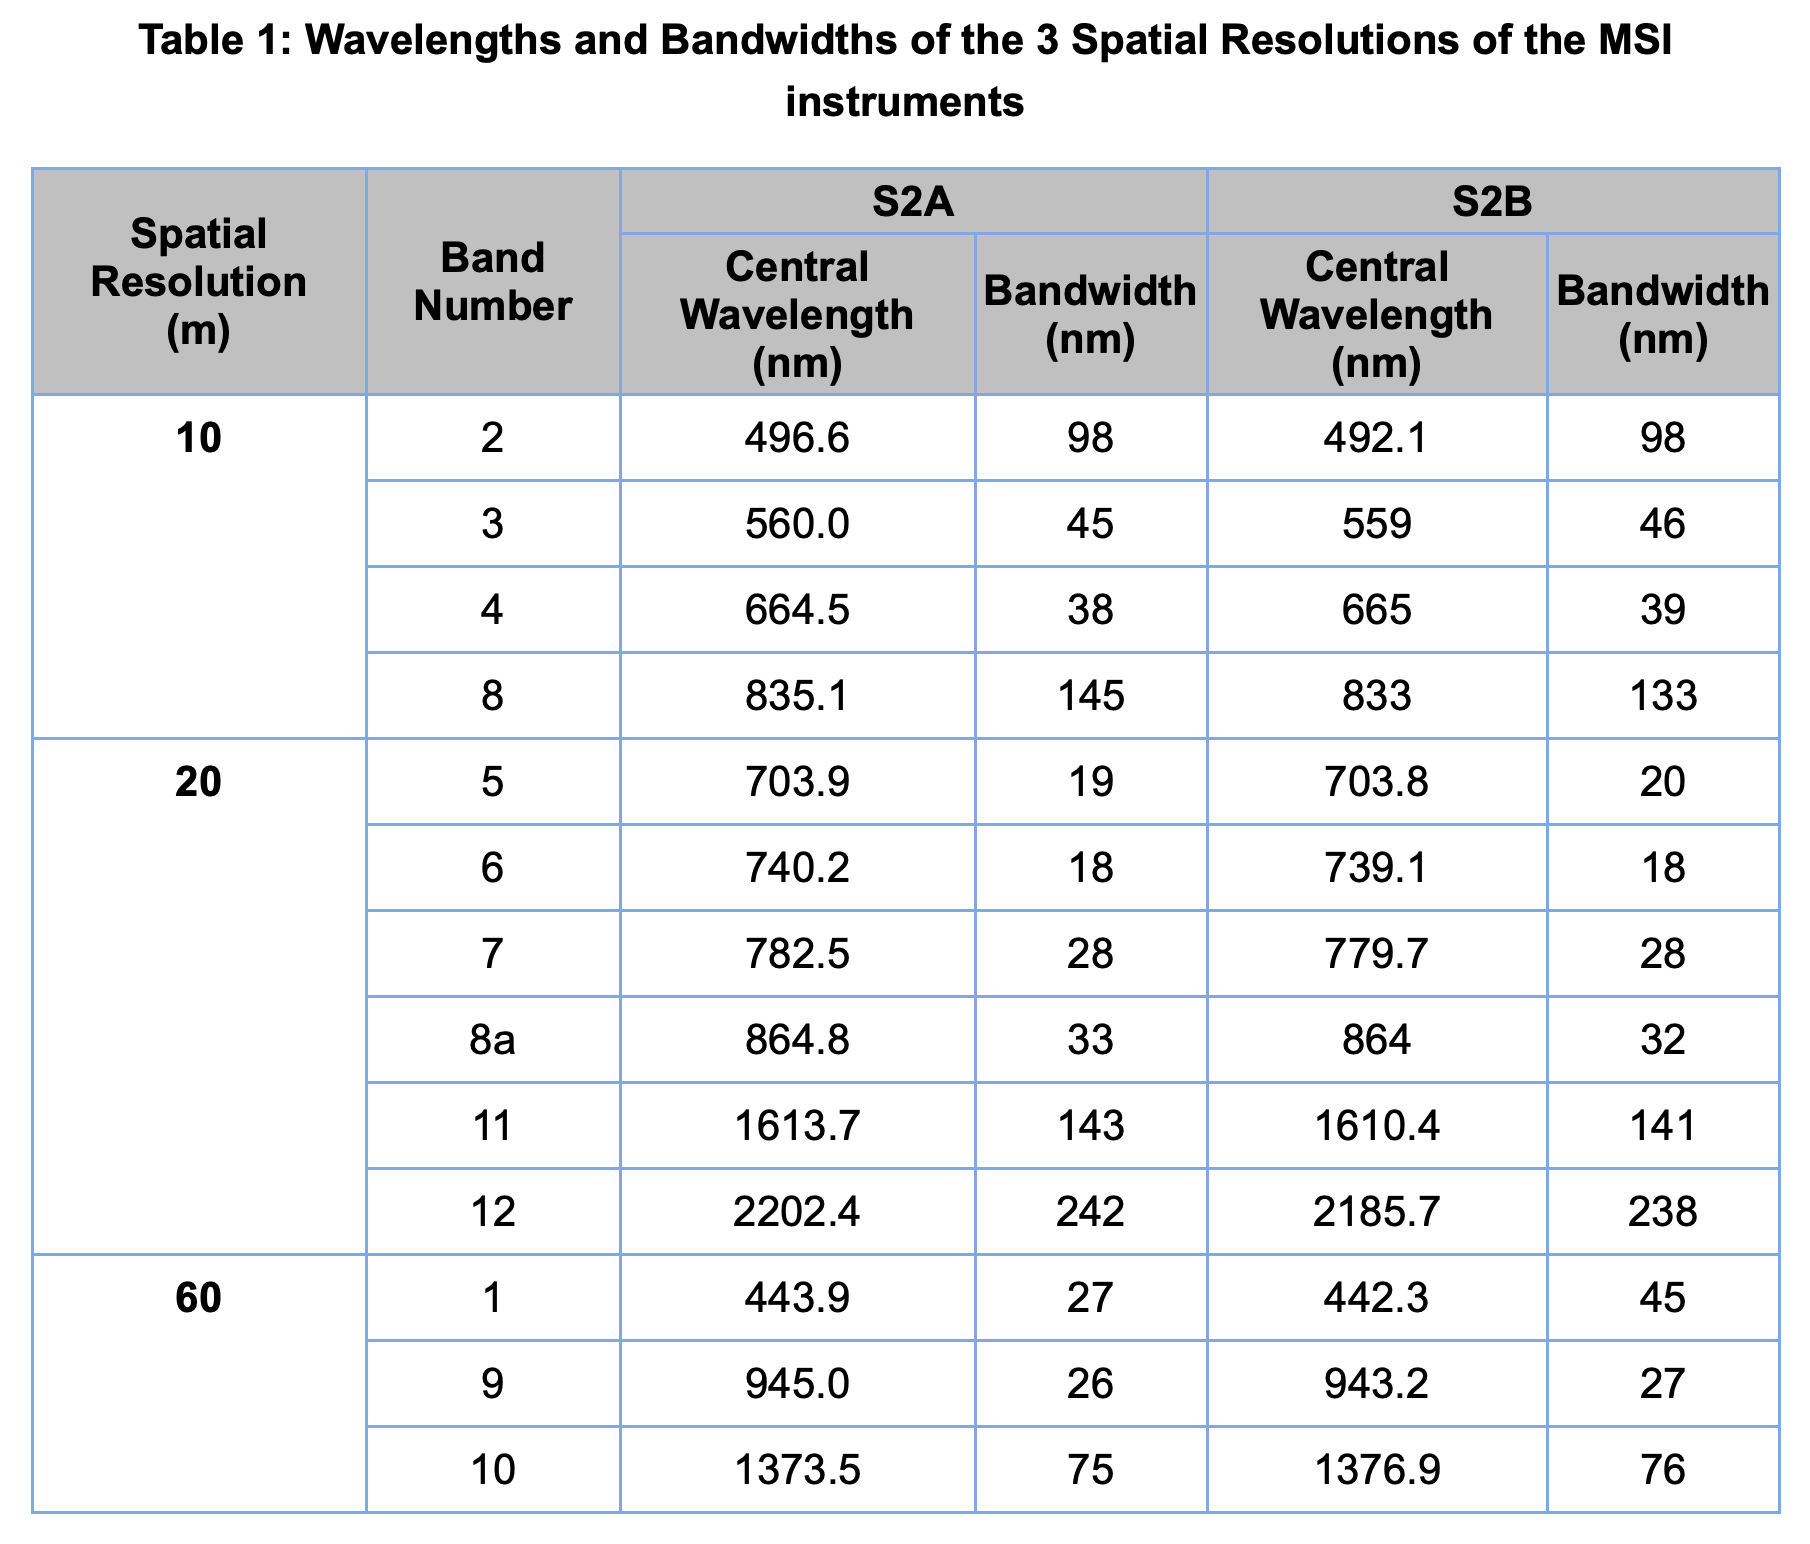

In [76]:
IPython.display.Image('assets/Screenshot 2019-09-07 at 16.20.22.png')

In [77]:
# red = skimage.io.imread(band4_file, as_gray=True)  # load red
# green = skimage.io.imread(band3_file, as_gray=True)  # load green
# blue = skimage.io.imread(band2_file, as_gray=True)  # load blue
# nir = skimage.io.imread(band5_file, as_gray=True)

In [78]:
band2 = rio.open(band2_file, driver='JP2OpenJPEG') #Blue
band3 = rio.open(band3_file, driver='JP2OpenJPEG') #Green
band4 = rio.open(band4_file, driver='JP2OpenJPEG') #Red
band8 = rio.open(band8_file, driver='JP2OpenJPEG') #Near Infra-red
TCI = rio.open(TCI_file, driver='JP2OpenJPEG')

In [79]:
print(band2)

<open DatasetReader name='input/T36SYA_20190829T081601_B02.jp2' mode='r'>


In [80]:
blue = band2.read()
green = band3.read()
red = band4.read()
nir = band8.read()

In [81]:
# Bands are stored as Numpy arrays
print(type(blue))

<class 'numpy.ndarray'>


In [82]:
blue.shape

(1, 10980, 10980)

In [83]:
stacked = np.stack((red, green, blue, nir), axis=1)

In [84]:
stacked = stacked.squeeze()

In [85]:
stacked.shape

(4, 10980, 10980)

In [86]:
# The dimensions of a single pixel in meters
band2.res

(10.0, 10.0)

In [87]:
# Number of rows and columns. Since it is the same image, we will have the same number of rows and columns
print("Rows: {}, Columns: {}".format(band2.shape[0], band2.shape[1]))
print("Rows: {}, Columns: {}".format(band3.shape[0], band3.shape[1]))

Rows: 10980, Columns: 10980
Rows: 10980, Columns: 10980


In [88]:
#The below for loop creates a masked arreys of 0 = False to be able to show the image using "visual" library
bands = [np.ma.array(band, mask = 0) for band in [red.squeeze(),
                                                  green.squeeze(),blue.squeeze()]]

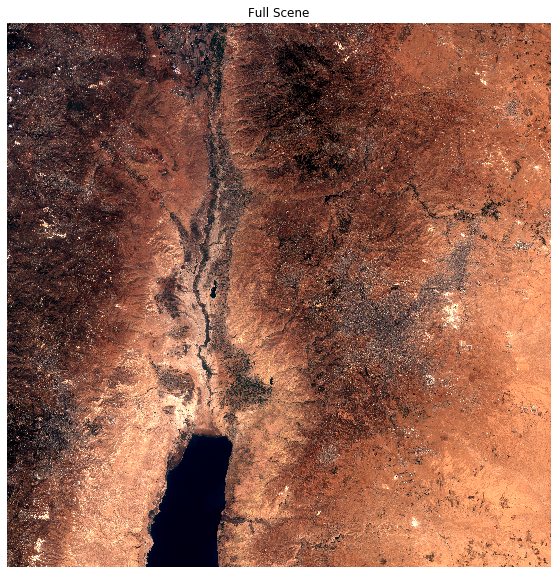

In [89]:
import visual
visual.plot_image(bands, title='Full Scene');

## Cropping

The images improted above are full images from Sentinel-2. To be able to run our analysis on limited resources, we will crop the images to train the model on a small area and then test it on another area. We will use fiona to upload a shapefile built using QGIS program.
The shape file is polygon.

In [90]:
with fiona.open("input/test2.shp", "r") as train:
    features = [feature["geometry"] for feature in train]

In [91]:
print('coordinates:')
features

coordinates:


[{'type': 'Polygon',
  'coordinates': [[(765774.2266820574, 3598465.3056818517),
    (773676.1839186761, 3598446.0795085267),
    (773666.5708320136, 3595100.725349958),
    (765812.6790287076, 3595119.9515232835),
    (765774.2266820574, 3598465.3056818517)]]}]

In [92]:
with fiona.open("input/small_patch.shp", "r") as patch:
    features2 = [feature["geometry"] for feature in patch]

In [93]:
print('coordinates:')
features2

coordinates:


[{'type': 'Polygon',
  'coordinates': [[(765675.6395636862, 3546684.393091213),
    (769782.2790208835, 3546739.311003716),
    (769818.8909625524, 3543157.44271044),
    (765565.8037386794, 3543126.9327590493),
    (765675.6395636862, 3546684.393091213)]]}]

for more details regarding making the shapefile document, please see the below youtube link.

https://www.youtube.com/watch?v=1KqWDXYuYMs&t=141s

- The above coordinates are values expressed as X and Y from a coordinate reference system (CRS) called "projected coordinate reference system". To be able to transform these X and Y values to the usual latitude/longtitude system, we need to convert the coordinates to something called "geographic coordinate reference system". This can be done by using pyproj library.

In [94]:
#We can find the epsg using rasterio. (EPSG stands for European Petroleum Survey Group)
rio.open(band4_file).crs

CRS.from_epsg(32636)

In [95]:
#Googling epsg 32636 will sow us the proj, zone and ellps for our area of interest (image location)
P = pyproj.Proj(proj='utm', zone=36, ellps='WGS84', preserve_units=True)

def XY_To_LonLat(x,y):
    return P(x,y,inverse=True)

In [96]:
for coo in features[0]['coordinates'][0]:
    print(XY_To_LonLat(coo[0], coo[1]))

(35.828467040880874, 32.49170504594513)
(35.91246475912281, 32.489614257612764)
(35.91139149707343, 32.45947682958229)
(35.827932500971116, 32.461553856301016)
(35.828467040880874, 32.49170504594513)


In [97]:
#Will re-create the shapefiles using osmnx to be able to plot the shapes on folium

In [98]:
test_polygon = ox.Polygon(((35.828467040880874, 32.49170504594513),
                           (35.91246475912281, 32.489614257612764),
                           (35.91139149707343, 32.45947682958229),
                           (35.827932500971116, 32.461553856301016),
                           (35.828467040880874, 32.49170504594513)))

In [99]:
for coo in features2[0]['coordinates'][0]:
    print(XY_To_LonLat(coo[0], coo[1]))

(35.812981747942054, 32.02515767928323)
(35.85643241279788, 32.02468089834948)
(35.855817933007756, 31.992397550123318)
(35.81084075103356, 31.993127525428427)
(35.812981747942054, 32.02515767928323)


In [100]:
patch_polygon = ox.Polygon(((35.812981747942054, 32.02515767928323),
                            (35.85643241279788, 32.02468089834948),
                            (35.855817933007756, 31.992397550123318),
                            (35.81084075103356, 31.993127525428427),
                            (35.812981747942054, 32.02515767928323)))

In [101]:
from folium import plugins
m = folium.Map([32.25, 35.9], zoom_start=9, tiles='cartodbpositron')
# folium.GeoJson(train_polygon).add_to(m)
folium.GeoJson(test_polygon).add_to(m)
folium.GeoJson(patch_polygon).add_to(m)
folium.LatLngPopup().add_to(m)
m

In [102]:
#using the above coordinates (for the test) to crop our bands
with rio.open(band4_file) as src4:
    out_image4, out_transform4 = rio.mask.mask(src4, features, crop=True)
    out_meta4 = src4.meta.copy()

In [103]:
#Repeating the above for the remaining bands
with rio.open(band3_file) as src3:
    out_image3, out_transform3 = rio.mask.mask(src3, features, crop=True)
    out_meta3 = src3.meta.copy()

with rio.open(band2_file) as src2:
    out_image2, out_transform2 = rio.mask.mask(src2, features, crop=True)
    out_meta2 = src2.meta.copy()

with rio.open(band8_file) as src8:
    out_image8, out_transform8 = rio.mask.mask(src8, features, crop=True)
    out_meta8 = src8.meta.copy()

In [104]:
out_meta4.update({
    "driver": "GTiff",
    "height": out_image4.shape[1],
    "width": out_image4.shape[2],
    "transform": out_transform4
})
with rio.open('output/T36SYA_20190829T081601_B04.TIF', "w",
              **out_meta4) as dest4:
    dest4.write(out_image4)

out_meta3.update({
    "driver": "GTiff",
    "height": out_image3.shape[1],
    "width": out_image3.shape[2],
    "transform": out_transform3
})
with rio.open('output/T36SYA_20190829T081601_B03.TIF', "w",
              **out_meta3) as dest3:
    dest3.write(out_image3)

out_meta2.update({
    "driver": "GTiff",
    "height": out_image2.shape[1],
    "width": out_image2.shape[2],
    "transform": out_transform2
})
with rio.open('output/T36SYA_20190829T081601_B02.TIF', "w",
              **out_meta2) as dest2:
    dest2.write(out_image2)

out_meta8.update({
    "driver": "GTiff",
    "height": out_image8.shape[1],
    "width": out_image8.shape[2],
    "transform": out_transform8
})
with rio.open('output/T36SYA_20190829T081601_B08.TIF', "w",
              **out_meta8) as dest8:
    dest8.write(out_image8)

In [105]:
#using the above coordinates (for the train) to crop our bands
with rio.open(band4_file) as src4:
    out_image4, out_transform4 = rio.mask.mask(src4, features2, crop=True)
    out_meta4 = src4.meta.copy()
with rio.open(band3_file) as src3:
    out_image3, out_transform3 = rio.mask.mask(src3, features2, crop=True)
    out_meta3 = src3.meta.copy()

with rio.open(band2_file) as src2:
    out_image2, out_transform2 = rio.mask.mask(src2, features2, crop=True)
    out_meta2 = src2.meta.copy()

with rio.open(band8_file) as src8:
    out_image8, out_transform8 = rio.mask.mask(src8, features2, crop=True)
    out_meta8 = src8.meta.copy()

In [106]:
out_meta4.update({
    "driver": "GTiff",
    "height": out_image4.shape[1],
    "width": out_image4.shape[2],
    "transform": out_transform4
})
with rio.open('output/T36SYA_20190829T081601_B04_test.TIF', "w",
              **out_meta4) as dest4:
    dest4.write(out_image4)

out_meta3.update({
    "driver": "GTiff",
    "height": out_image3.shape[1],
    "width": out_image3.shape[2],
    "transform": out_transform3
})
with rio.open('output/T36SYA_20190829T081601_B03_test.TIF', "w",
              **out_meta3) as dest3:
    dest3.write(out_image3)

out_meta2.update({
    "driver": "GTiff",
    "height": out_image2.shape[1],
    "width": out_image2.shape[2],
    "transform": out_transform2
})
with rio.open('output/T36SYA_20190829T081601_B02_test.TIF', "w",
              **out_meta2) as dest2:
    dest2.write(out_image2)

out_meta8.update({
    "driver": "GTiff",
    "height": out_image8.shape[1],
    "width": out_image8.shape[2],
    "transform": out_transform8
})
with rio.open('output/T36SYA_20190829T081601_B08_test.TIF', "w",
              **out_meta8) as dest8:
    dest8.write(out_image8)

In [139]:
#Loading 0.6-meter per pixel resolution image
new_image = rio.open('input/m_3411661_ne_11_060_20180907/m_3411661_ne_11_060_20180907.tif')

In [132]:
new_image.res

(0.6, 0.6)

In [133]:
#the image has 4 bands, r,g,b and nir
new_image.read()

array([[[180, 180, 185, ..., 166, 168, 169],
        [182, 181, 162, ..., 168, 168, 168],
        [181, 181, 149, ..., 168, 169, 169],
        ...,
        [152, 153, 126, ..., 111, 102, 125],
        [148, 154, 119, ..., 151, 149, 154],
        [144, 145, 121, ..., 158, 161, 159]],

       [[170, 172, 185, ..., 156, 157, 157],
        [171, 172, 148, ..., 155, 157, 158],
        [171, 171, 131, ..., 156, 158, 157],
        ...,
        [138, 136, 111, ..., 102,  96, 116],
        [132, 137, 100, ..., 134, 131, 136],
        [136, 131, 106, ..., 141, 141, 140]],

       [[147, 151, 180, ..., 137, 137, 137],
        [150, 153, 147, ..., 137, 137, 138],
        [150, 153, 124, ..., 136, 138, 138],
        ...,
        [108, 109,  90, ...,  79,  74,  89],
        [106, 109,  87, ..., 105, 102, 108],
        [107, 110,  92, ..., 112, 114, 111]],

       [[156, 154, 155, ..., 138, 139, 139],
        [162, 157, 121, ..., 140, 139, 137],
        [161, 157, 102, ..., 141, 142, 142],
        ..

In [110]:
#cropping a train image
with fiona.open("input/m_3411661_ne_11_060_20180907/train_us.shp", "r") as train_us:
    features3 = [feature["geometry"] for feature in train_us]

In [111]:
features3

[{'type': 'Polygon',
  'coordinates': [[(552798.2047265447, 3775551.5398123153),
    (553826.1317714271, 3775552.93266739),
    (553840.0603221708, 3774756.2195648523),
    (552792.6333062472, 3774745.0767242573),
    (552798.2047265447, 3775551.5398123153)]]}]

In [112]:
#using the above coordinates (for the test) to crop our bands
with new_image as src1_us:
    out_image_us_train, out_transform_us_train = rio.mask.mask(src1_us, features3, crop=True)
    out_meta_us_train = src1_us.meta.copy()

In [113]:
out_meta_us_train.update({
    "driver": "GTiff",
    "height": out_image_us_train.shape[1],
    "width": out_image_us_train.shape[2],
    "transform": out_transform_us_train
})
with rio.open('output/train_us.TIF', "w",
              **out_meta_us_train) as dest1_us:
    dest1_us.write(out_image_us_train)

In [114]:
#cropping a test image
with fiona.open("input/m_3411661_ne_11_060_20180907/test_us.shp", "r") as test_us:
    features4 = [feature["geometry"] for feature in test_us]

In [120]:
with new_image as test_us:
    out_image_us_test, out_transform_us_test = rio.mask.mask(test_us, features4, crop=True)
    out_meta_us_test = test_us.meta.copy()

    
out_meta_us_test.update({
    "driver": "GTiff",
    "height": out_image_us_test.shape[1],
    "width": out_image_us_test.shape[2],
    "transform": out_transform_us_test
})
with rio.open('output/test_us.TIF', "w",
              **out_meta_us_test) as test_us:
    test_us.write(out_image_us_test)

In [121]:
#The below is to be able to show our AOI using folium map

In [122]:
new_image.crs

CRS.from_epsg(26911)

In [123]:
#Googling epsg 26911 will sow us the proj, zone and ellps for our area of interest (image location)
P2 = pyproj.Proj(proj='utm', zone=11, ellps='GRS80', preserve_units=True)

def XY_To_LonLat_2(x,y):
    return P2(x,y,inverse=True)

In [124]:
for coo in features3[0]['coordinates'][0]:
    print(XY_To_LonLat_2(coo[0], coo[1]))

(-116.42746880185805, 34.119477810590816)
(-116.41632262197439, 34.119437904817005)
(-116.41622096111638, 34.112252204785726)
(-116.42757821640832, 34.11220516735692)
(-116.42746880185805, 34.119477810590816)


In [125]:
test_us_polygon = ox.Polygon(((-116.42746880185805, 34.119477810590816), 
                              (-116.41632262197439, 34.119437904817005), 
                              (-116.41622096111638, 34.112252204785726), 
                              (-116.42757821640832, 34.11220516735692), 
                              (-116.42746880185805, 34.119477810590816)))

In [126]:
for coo in features4[0]['coordinates'][0]:
    print(XY_To_LonLat_2(coo[0], coo[1]))

(-116.38640632574682, 34.12183115352454)
(-116.3744781641823, 34.1218381871906)
(-116.37450205498332, 34.11420320628845)
(-116.38626695483099, 34.1142760007697)
(-116.38640632574682, 34.12183115352454)


In [127]:
train_us_polygon = ox.Polygon(((-116.38640632574682, 34.12183115352454), 
                               (-116.3744781641823, 34.1218381871906),
                               (-116.37450205498332, 34.11420320628845),
                               (-116.38626695483099, 34.1142760007697),
                               (-116.38640632574682, 34.12183115352454)))

In [128]:
from folium import plugins
m = folium.Map([34.12, -116.38], zoom_start=13, tiles='cartodbpositron')
folium.GeoJson(train_us_polygon).add_to(m)
folium.GeoJson(test_us_polygon).add_to(m)
folium.LatLngPopup().add_to(m)
m

End

In [140]:
#cropping a test image
with fiona.open("input/m_3411661_ne_11_060_20180907/test_2.shp", "r") as test_us2:
    features5 = [feature["geometry"] for feature in test_us2]
    
with new_image as test_us2:
    out_image_us_test2, out_transform_us_test2 = rio.mask.mask(test_us2, features5, crop=True)
    out_meta_us_test2 = test_us2.meta.copy()

    
out_meta_us_test2.update({
    "driver": "GTiff",
    "height": out_image_us_test2.shape[1],
    "width": out_image_us_test2.shape[2],
    "transform": out_transform_us_test2
})
with rio.open('output/test_us2.TIF', "w",
              **out_meta_us_test2) as test_us2:
    test_us2.write(out_image_us_test2)

for coo in features5[0]['coordinates'][0]:
    print(XY_To_LonLat_2(coo[0], coo[1]))
    
    


(-116.43733613697808, 34.123987002234365)
(-116.43570111465841, 34.12396055394918)
(-116.43572021761257, 34.122609151497954)
(-116.4373427255158, 34.12261028055224)
(-116.43733613697808, 34.123987002234365)


In [142]:
test_us2_polygon = ox.Polygon(((-116.43733613697808, 34.123987002234365),
                              (-116.43570111465841, 34.12396055394918),
                              (-116.43572021761257, 34.122609151497954),
                              (-116.4373427255158, 34.12261028055224),
                              (-116.43733613697808, 34.123987002234365)))

In [143]:
from folium import plugins
m = folium.Map([34.12, -116.38], zoom_start=13, tiles='cartodbpositron')
folium.GeoJson(train_us_polygon).add_to(m)
folium.GeoJson(test_us_polygon).add_to(m)
folium.GeoJson(test_us2_polygon).add_to(m)
folium.LatLngPopup().add_to(m)
m